Step 1: Loading Data...
Classes: ["Alzheimer's Disease" 'Frontotemporal Dementia' 'Lewy Body Dementia'
 "Parkinson's Disease" 'Vascular Dementia']
Step 2: Extracting BoW Features...
Feature Matrix Shape: (1312, 5000)

Step 3: Training MultinomialNB...
Running 10-Fold Cross-Validation...
Mean CV Accuracy: 0.6936 (+/- 0.0340)

Step 4: Plotting Learning Curves...


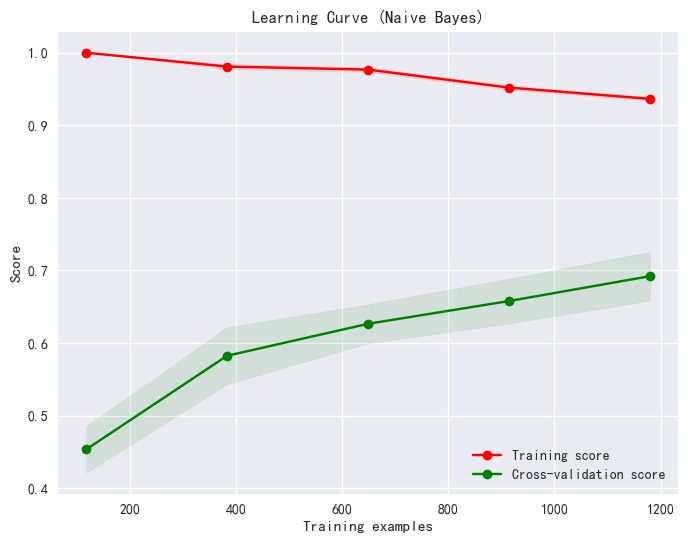


--- Classification Report ---
                         precision    recall  f1-score   support

    Alzheimer's Disease       0.64      0.57      0.60        68
Frontotemporal Dementia       0.81      0.75      0.78        59
     Lewy Body Dementia       0.61      0.67      0.64        64
    Parkinson's Disease       0.73      0.59      0.65        68
      Vascular Dementia       0.61      0.77      0.68        70

               accuracy                           0.67       329
              macro avg       0.68      0.67      0.67       329
           weighted avg       0.68      0.67      0.67       329



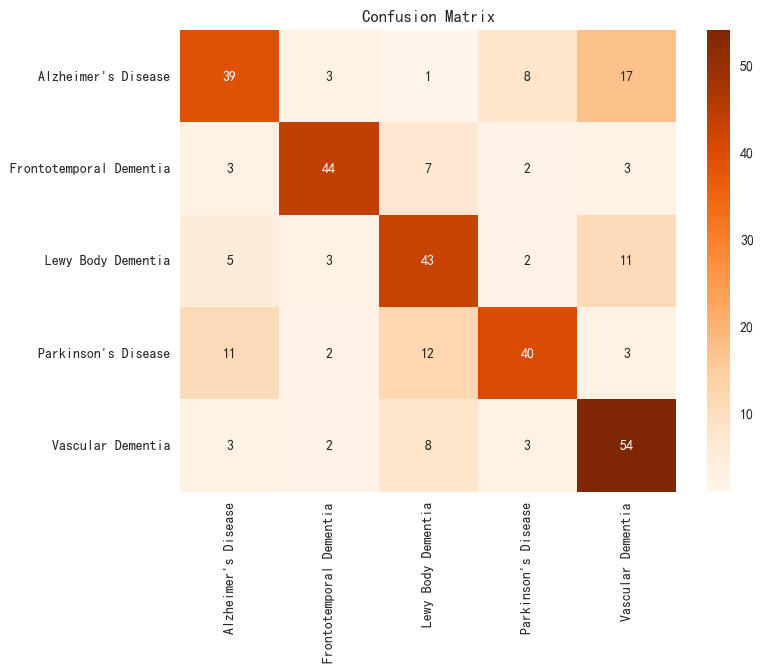

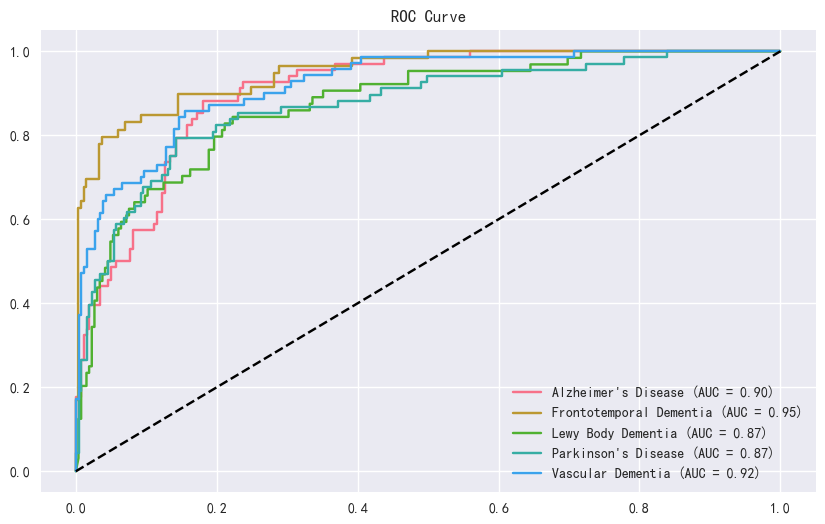


Step 6: Error Analysis...
Top Words in Errors: [('disease', np.int64(460)), ('patient', np.int64(73)), ('study', np.int64(61)), ('cognitive', np.int64(44)), ('result', np.int64(36)), ('clinical', np.int64(35)), ('brain', np.int64(31)), ('neurodegenerative', np.int64(30)), ('model', np.int64(28)), ('method', np.int64(27)), ('function', np.int64(26)), ('score', np.int64(26)), ('group', np.int64(25)), ('associated', np.int64(24)), ('including', np.int64(24)), ('protein', np.int64(24)), ('symptom', np.int64(24)), ('amyloid', np.int64(23)), ('analysis', np.int64(22)), ('related', np.int64(22))]

Step 7: SHAP Analysis (KernelExplainer)...


  0%|          | 0/20 [00:00<?, ?it/s]

SHAP Summary Plot for Class: Alzheimer's Disease


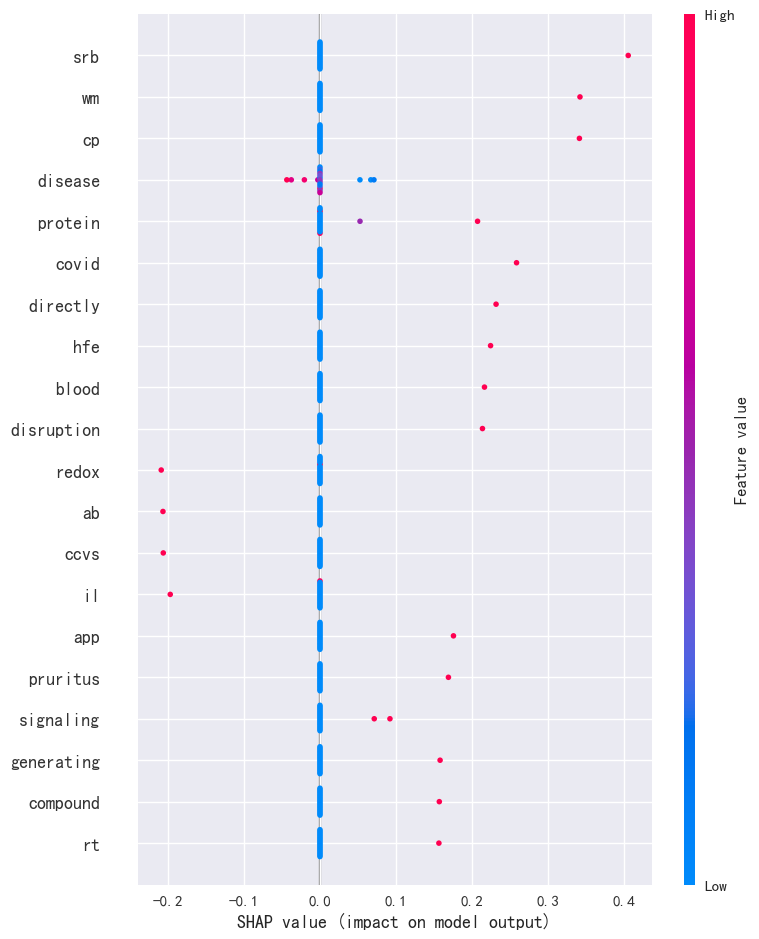

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import shap
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# ==========================================
# 1. 数据加载与预处理
# ==========================================
print("Step 1: Loading Data...")
try:
    df = pd.read_csv('../cleaned_data.csv')
except:
    df = pd.read_csv('cleaned_data.csv')

df['Cleaned_Content'] = df['Cleaned_Content'].fillna('')

le = LabelEncoder()
df['Label_Encoded'] = le.fit_transform(df['Label'])
label_names = le.classes_
print(f"Classes: {label_names}")

X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    df['Cleaned_Content'], df['Label_Encoded'], 
    test_size=0.2, random_state=42, stratify=df['Label_Encoded']
)

# ==========================================
# 2. 特征工程: BoW (CountVectorizer)
# ==========================================
print("Step 2: Extracting BoW Features...")
vectorizer = CountVectorizer(max_features=5000, stop_words='english')

X_train_features = vectorizer.fit_transform(X_train_raw)
X_test_features = vectorizer.transform(X_test_raw)
feature_names = vectorizer.get_feature_names_out()

print(f"Feature Matrix Shape: {X_train_features.shape}")

# ==========================================
# 3. 模型训练: MultinomialNB
# ==========================================
print("\nStep 3: Training MultinomialNB...")
nb_model = MultinomialNB()

print("Running 10-Fold Cross-Validation...")
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(nb_model, X_train_features, y_train, cv=cv, scoring='accuracy')

print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

nb_model.fit(X_train_features, y_train)

# ==========================================
# 4. 学习曲线
# ==========================================
print("\nStep 4: Plotting Learning Curves...")
def plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(nb_model, "Learning Curve (Naive Bayes)", X_train_features, y_train, cv=cv, n_jobs=-1)

# ==========================================
# 5. 评估与可视化
# ==========================================
y_pred = nb_model.predict(X_test_features)
y_prob = nb_model.predict_proba(X_test_features)

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=label_names))

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 6))
y_test_bin = pd.get_dummies(y_test).values
if y_test_bin.shape[1] == len(label_names):
    for i, class_label in enumerate(label_names):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

# ==========================================
# 6. 误差分析
# ==========================================
print("\nStep 6: Error Analysis...")
misclassified_indices = np.where(y_test != y_pred)[0]
# ... Standard Code ...
if len(misclassified_indices) > 0:
    error_docs = X_test_raw.iloc[misclassified_indices]
    from sklearn.feature_extraction.text import CountVectorizer
    error_cv = CountVectorizer(stop_words='english', max_features=20)
    try:
        error_counts = error_cv.fit_transform(error_docs)
        error_words = error_cv.get_feature_names_out()
        error_word_freq = np.asarray(error_counts.sum(axis=0)).flatten()
        print(f"Top Words in Errors: {sorted(dict(zip(error_words, error_word_freq)).items(), key=lambda x: x[1], reverse=True)}")
    except: pass

# ==========================================
# 7. 可解释性 SHAP
# ==========================================
print("\nStep 7: SHAP Analysis (KernelExplainer)...")
try:
    # KernelExplainer for MultinomialNB
    # Use a small background sample (converted to dense for safety, though sparse might work)
    # Using kmeans summary for dense background if possible, or just random samples
    background = shap.kmeans(X_train_features.toarray(), 10) 
    
    explainer = shap.KernelExplainer(nb_model.predict_proba, background)
    
    # Analyze a small number of test samples due to speed
    X_shap_sample = X_test_features[:20].toarray()
    shap_values = explainer.shap_values(X_shap_sample)
    
    target_idx = 0 
    if isinstance(shap_values, list):
        sv = shap_values[target_idx]
    else:
        # Check logic: if 3D array (samples, features, classes)
        if len(np.array(shap_values).shape) == 3:
             sv = shap_values[:, :, target_idx]
        else:
             sv = shap_values

    print(f"SHAP Summary Plot for Class: {label_names[target_idx]}")
    shap.summary_plot(sv, X_shap_sample, feature_names=feature_names, show=False)
    plt.show()
except Exception as e:
    print(f"SHAP Analysis skipped: {e}")